# Flow distortion of the wind field

We need to make sure that neither the ship nor the SBs distort the wind field. To do this we compare with ERA5 winds, and the platforms heading.

## Load modules

In [ ]:
%matplotlib inline
%pylab inline
import xarray as xr
import pandas as pd
import datetime
import glob
import matplotlib.dates as mdates
import gsw
import glidertools as gt
from tqdm.notebook import tqdm_notebook as tqdm
from cmocean import cm as cmo  
import os
import pathlib
from matplotlib.ticker import MaxNLocator
import geomag
import cartopy.crs as ccrs
import matplotlib
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.image as mpimg
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scipy
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.animation import FuncAnimation
import cartopy.feature as cfeature
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
#from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
#from scipy import stats    #Used for 2D binned statistics
#from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
#import cartopy.crs as ccrs
from scipy import stats
#from scipy import signal, ndimage
from scipy import fft as spfft
from scipy.fft import fft 
from scipy.stats import chi2
from scipy.special import digamma
#function for coverting Matlab's datenum into Python's datetime
#from https://gist.github.com/victorkristof/b9d794fe1ed12e708b9d
#with modifications to support array input and output

mpl.rcParams['animation.ffmpeg_path'] = r"/Users/xedhjo/Documents/Python/extra/ffmpeg"

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1

from IPython.display import display, Markdown

def print_with_font_size(text, fs=20):
    # Format the output with the desired font size
    print_output = f"<span style='font-size: {fs}px;'>{text}</span>"
    display(Markdown(print_output))

print = print_with_font_size

def rot_ticks(axs,rot,ha):
    for xlabels in axs.get_xticklabels():
                xlabels.set_rotation(rot)
                xlabels.set_ha(ha)
                
def time_ticks_h(ax,interval=[0,6,12,18]):
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%d %b"))
    
def time_ticks_d(ax,majint,minint):
    ax.xaxis.set_minor_locator(mdates.HourLocator(minint))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter(""))
    ax.xaxis.set_major_locator(mdates.DayLocator(majint))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    
def gridlines(ax,lon_tick,lat_tick):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      x_inline=False, y_inline=False,
                  linewidth=0.75, alpha=0.5, linestyle='--',ylocs = matplotlib.ticker.MultipleLocator(base=lat_tick),xlocs = matplotlib.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xpadding=10
    gl.ypadding=10
    
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Parameters
    ----------
        lat: Latitude in degree
        
    Returns:
        The Coriolis frequecy at latitude lat
    """    
    omega=7.2921159e-5;
    return 2*np.sin(lat*2*np.pi/360)*omega*(3600)*24


def fix_xticks(ax,ds):
    
    if  mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 2 :
        ax[0].xaxis.set_minor_locator(mdates.HourLocator(np.arange(0,24,6)))
        ax[0].xaxis.set_major_locator(mdates.HourLocator(np.arange(0,24,24)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
        ax[0].set_xlim(ds.time[0] - np.timedelta64(6,'H'),ds.time[-1] + np.timedelta64(6,'H'))

    if  np.logical_and(mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 2, mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 7):
        ax[0].xaxis.set_minor_locator(mdates.HourLocator([0,12]))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
        ax[0].set_xlim(ds.time[0] - np.timedelta64(1,'D'),ds.time[-1] + np.timedelta64(1,'D'))

    if  np.logical_and(mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 7, mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 15):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(2,32,2)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter(""))
        ax[-1].set_xlabel('2023')
        ax[0].set_xlim(ds.time[0] - np.timedelta64(1,'D'),ds.time[-1] + np.timedelta64(1,'D'))

    if  np.logical_and(mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 15, mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 30):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator([5,10,15,20,25,30]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        #ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
        ax[0].set_xlim(ds.time[0] - np.timedelta64(2,'D'),ds.time[-1] + np.timedelta64(2,'D'))

    if  mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 30:
        ax[0].xaxis.set_major_locator(mdates.MonthLocator())
        ax[0].xaxis.set_minor_locator(mdates.DayLocator([1,5,10,15,20,25]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%B"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
        ax[0].set_xlim(ds.time[0] - np.timedelta64(3,'D'),ds.time[-1] + np.timedelta64(3,'D'))

    rot_ticks(ax[-1],0,'center')
    ax[0].set_xlabel('')


wind_c2 = ListedColormap(['#FCC681','#FF819E','#FF819E','#A0A3E0','#A0A3E0','#99D4E5','#99D4E5','#FCC681']) # Soft pastels, use this

kc = '#006699'
sdc = '#ff6600'
ppc = 'crimson'
sc = 'goldenrod'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
sbk = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/kringla_quicche_corrected.nc')
sbpp = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/pimpim_quicche_full_corrected.nc')
ship = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/ship_met_quicche_corrected.nc')

era5 = xr.open_dataset('/Users/xedhjo/Documents/Projects/QUICCHE/data/ERA5_QUICCHE.nc').mean('expver',keep_attrs=True)

era5['t2m'].values = era5['t2m'].values - 273.15
era5['sst'].values = era5['sst'].values - 273.15
era5['skt'].values = era5['skt'].values - 273.15

In [10]:
def angle_diff(ds,var1,var2):
    return np.angle(np.exp(1j * np.deg2rad(ds[var1])) / np.exp(1j * np.deg2rad(ds[var2].values)), deg=True)

In [16]:
ship['doy'] = xr.DataArray(mdates.date2num(ship['time']) - mdates.date2num(np.datetime64('2023-01-02')),dims='time')
ship = ship.set_coords('doy')
ship['hrw'] = ('time'),angle_diff(ship,'SH','TI')

## Find time steps in the high resolution datasets that match ERA5

In [18]:
def process_ship_data(ship, era5):
    """
    Process ship and ERA5 data.

    Parameters:
    - ship (xarray.Dataset): Ship data containing various variables like time, latitude, longitude, etc.
    - era5 (xarray.Dataset): ERA5 data containing meteorological information.

    Returns:
    - ship_1h (xarray.Dataset): Processed ship data with a one-hour time interval.
    """

    # Extract unique hourly times from ship data
    mt = [time for time in ship.time.values if time in np.unique(ship.time.dt.floor('H').values)]
    mi = [np.where(ship.time.values == time)[0][0] for time in mt]
    ship_1h = ship.isel(time=mi)

    t = ship_1h.time.values

    # Interpolate and round latitude and longitude to the nearest 0.25 degrees
    lats = (np.round(ship_1h['LA'].interpolate_na('time') * 4) / 4)
    lons = (np.round(ship_1h['LO'].interpolate_na('time') * 4) / 4)

    # Retrieve ERA5 data for corresponding time, latitude, and longitude
    temp = []
    for i in range(len(t)):
        temp.append(era5.sel(time=t[i]).sel(longitude=lons[i]).sel(latitude=lats[i]))
    
    era5_ship = xr.concat(temp, dim='time')
    era5_ship['wind_speed'] = np.sqrt(era5_ship['u10']**2 + era5_ship['v10']**2)

    # Calculate wind direction in degrees
    era5_ship['wind_dir'] = ('time'), ((np.arctan2(era5_ship['u10'], era5_ship['v10']) * 180 / np.pi + 180) % 360).values
    era5_ship['doy'] = ship_1h['doy']
    era5_ship = era5_ship.set_coords('doy')

    # Calculate and add 'hrw_era' variable
    ship_1h['hrw_era'] = ('time'), -np.angle(np.exp(1j * np.deg2rad(ship_1h['SH'])) / np.exp(1j * np.deg2rad(era5_ship['wind_dir'].values)), deg=True)

    # Interpolate missing data and remove the 'flags' variable
    ship_1h = ship_1h.drop('flags').interpolate_na('time')

    return ship_1h


### Ship

In [19]:
ship_1h = process_ship_data(ship, era5)

<span style='font-size: 20px;'>We lose 17.5% of the data</span>

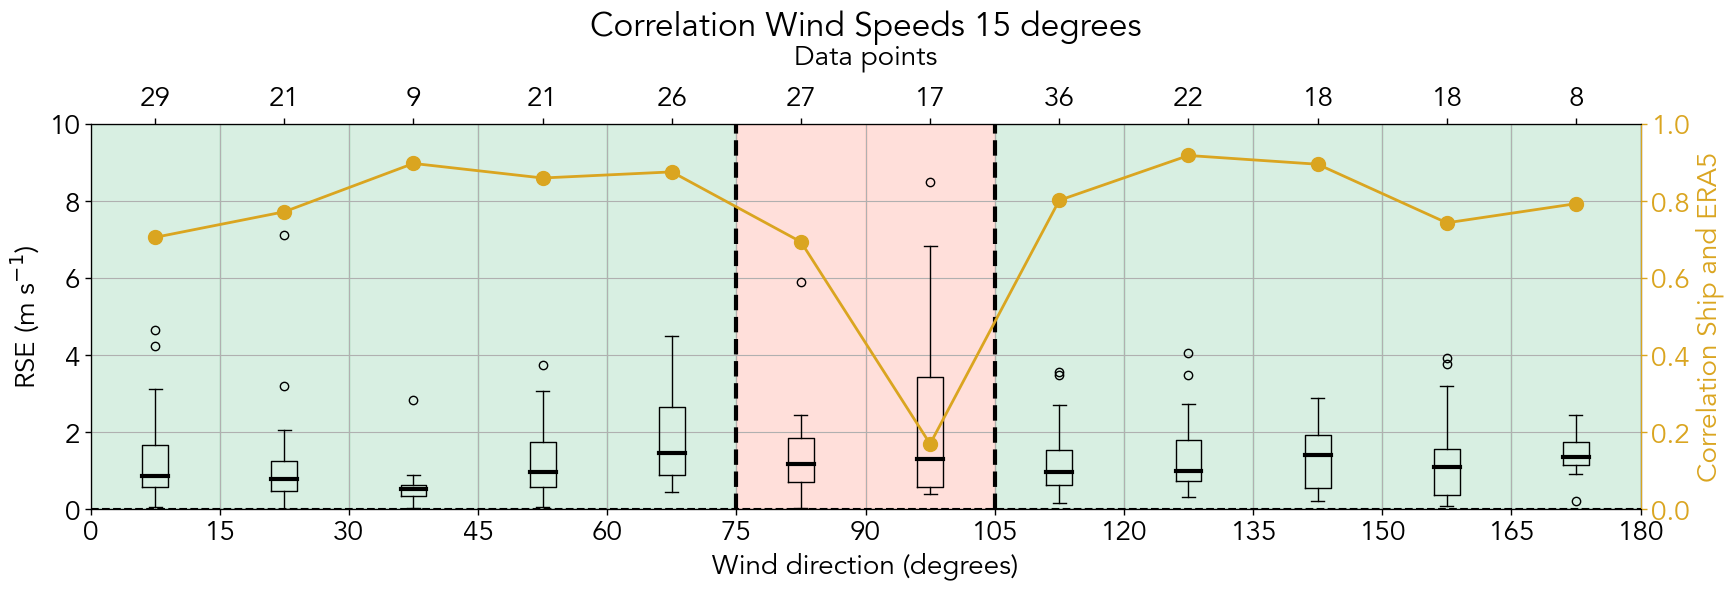

In [27]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 5))

# Interval for binning the data
da = 15
n = []  # List to store the number of data points in each interval
R = []  # List to store the correlation coefficients

# Create additional axes
top_ax = ax.twiny()  # Top x-axis
right_ax = ax.twinx()  # Right y-axis
pos = np.arange(0, 181-da, da)

# Iterate over the interval of 0 to 180 (inclusive) with step size da
for i in pos:
    # Create a mask to select data within the current interval
    mask  = ((ship_1h['hrw_era']) > i) & ((ship_1h['hrw_era']) < i + da)
    
    # Count the number of data points in the current interval
    m = mask.sum().values
    n.append(m)
    
    # Generate random values for x-coordinate jittering of scatter plot
    rand = np.random.rand(m)
    
    # Apply the mask to select the relevant data for the boxplot
    ship_data = np.sqrt((np.square(ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed'])))
    
    # Calculate the correlation coefficient
    _, _, r, _, _ = stats.linregress(ship_1h.where(mask, drop=True)['u10'], era5_ship.where(mask, drop=True)['wind_speed'])
    
    R.append(r ** 2)

    # Create the boxplot using the selected data and position
    position = [i]
    ax.boxplot(ship_data, positions=[position[0] + da/2], widths=3, medianprops={'color': 'k','lw':3,'ls':'-'},zorder=2)

# Customize xticks and labels for the bottom axis
xticks = np.arange(0, 181, da)
xtick_labels = [str(x) for x in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set(xlabel='Wind direction (degrees)', ylabel='RSE (m s$^{-1}$)', ylim=(0, 10), xlim=(0,180))
ax.axhline(0, ls='--', c='k', zorder=2)

# Customize xticks and labels for the top axis
xticks = np.arange(da/2, 181, da)
xtick_labels = [str(x) for x in n]

top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticks(xticks)
top_ax.set_xticklabels(xtick_labels)
top_ax.set_xlabel('Data points', labelpad=15)

# Set color and plot the correlation values
c = "goldenrod"
right_ax.plot(np.arange(da/2, 181, da), R, c=c, marker='.', ms=20, lw=2, zorder=1)
right_ax.set(ylim=(0, 1), title=f'Correlation Wind Speeds {da} degrees',xlim=(0,180))
right_ax.tick_params(axis='y', colors=c)
right_ax.set_ylabel('Correlation Ship and ERA5', color=c)
right_ax.spines['right'].set_color(c)

# Add gridlines
ax.grid(zorder=3)
lim = 0.7

def plot_colored_areas():

    y_limits = ax.get_ylim()
    
    for i in range(len(R)):
        if R[i] < lim:
            color = 'tomato'
        else:
            color = 'mediumseagreen'
        
        ax.fill([pos[i], pos[i] + da, pos[i] + da, pos[i], pos[i]],
                [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]],
                color=color, alpha=0.2)
        
        if i < len(R) - 1:
            if (R[i] < lim and R[i + 1] >= lim) or (R[i] >=lim and R[i + 1] < lim):
                ax.axvline(pos[i]+da, c='k', ls='--', lw=3)


plot_colored_areas()

print(f'We lose {(np.array(n)[np.where(np.array(R) < lim)[0]].sum() / np.array(n).sum() * 100).round(1)}% of the data')

<span style='font-size: 20px;'>We lose 19.3% of the data</span>

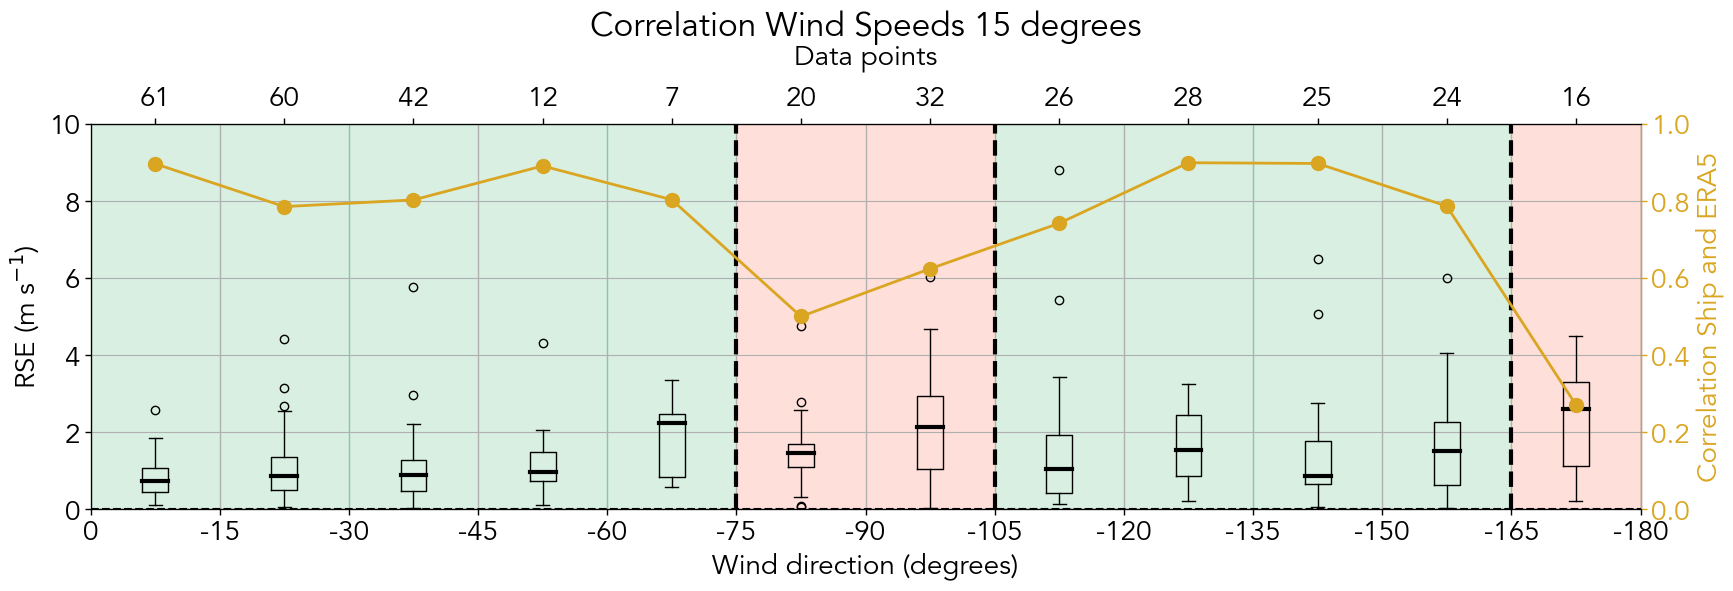

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 5))

# Interval for binning the data
da = 15
n = []  # List to store the number of data points in each interval
R = []  # List to store the correlation coefficients

# Create additional axes
top_ax = ax.twiny()  # Top x-axis
right_ax = ax.twinx()  # Right y-axis
pos = np.arange(0, 181-da, da)

# Iterate over the interval of 0 to 180 (inclusive) with step size da
for i in pos:
    # Create a mask to select data within the current interval
    mask  = ((ship_1h['hrw_era']) < -i) & ((ship_1h['hrw_era']) > -i - da)
    
    # Count the number of data points in the current interval
    m = mask.sum().values
    n.append(m)
    
    # Generate random values for x-coordinate jittering of scatter plot
    rand = np.random.rand(m)
    
    # Apply the mask to select the relevant data for the boxplot
    ship_data = np.sqrt((np.square(ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed'])))
    
    # Calculate the correlation coefficient
    _, _, r, _, _ = stats.linregress(ship_1h.where(mask, drop=True)['u10'], era5_ship.where(mask, drop=True)['wind_speed'])
    
    R.append(r ** 2)

    # Create the boxplot using the selected data and position
    position = [i]
    ax.boxplot(ship_data, positions=[position[0] + da/2], widths=3, medianprops={'color': 'k','lw':3,'ls':'-'},zorder=2)

# Customize xticks and labels for the bottom axis
xticks = np.arange(0, 181, da)
xtick_labels = [str(-x) for x in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set(xlabel='Wind direction (degrees)', ylabel='RSE (m s$^{-1}$)', ylim=(0, 10), xlim=(0,180))
ax.axhline(0, ls='--', c='k', zorder=2)

# Customize xticks and labels for the top axis
xticks = np.arange(da/2, 181, da)
xtick_labels = [str(x) for x in n]

top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticks(xticks)
top_ax.set_xticklabels(xtick_labels)
top_ax.set_xlabel('Data points', labelpad=15)

# Set color and plot the correlation values
c = "goldenrod"
right_ax.plot(np.arange(da/2, 181, da), R, c=c, marker='.', ms=20, lw=2, zorder=1)
right_ax.set(ylim=(0, 1), title=f'Correlation Wind Speeds {da} degrees',xlim=(0,180))
right_ax.tick_params(axis='y', colors=c)
right_ax.set_ylabel('Correlation Ship and ERA5', color=c)
right_ax.spines['right'].set_color(c)

# Add gridlines
ax.grid(zorder=3)
lim = 0.7

def plot_colored_areas():

    y_limits = ax.get_ylim()
    
    for i in range(len(R)):
        if R[i] < lim:
            color = 'tomato'
        else:
            color = 'mediumseagreen'
        
        ax.fill([pos[i], pos[i] + da, pos[i] + da, pos[i], pos[i]],
                [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]],
                color=color, alpha=0.2)
        
        if i < len(R) - 1:
            if (R[i] < lim and R[i + 1] >= lim) or (R[i] >=lim and R[i + 1] < lim):
                ax.axvline(pos[i]+da, c='k', ls='--', lw=3)


plot_colored_areas()

print(f'We lose {(np.array(n)[np.where(np.array(R) < lim)[0]].sum() / np.array(n).sum() * 100).round(1)}% of the data')

Maybe a polar plot will show this better...

In [30]:
from scipy import stats
import numpy as np
from matplotlib.cm import ScalarMappable

def calculate_interval_statistics(ship_1h, era5_ship, interval_size=15):
    """
    Calculate interval statistics including RMSE, root standard error of RMSE, and correlation coefficients.

    This function calculates various statistics within specified intervals for two datasets.

    Args:
        ship_1h (pd.DataFrame): DataFrame containing ship data.
        era5_ship (pd.DataFrame): DataFrame containing ERA5 ship data.
        interval_size (int, optional): Size of each interval for data binning. Default is 15.

    Returns:
        tuple: A tuple containing three lists - RMSE (Root Mean Square Error),
               root_std_err (Root Standard Error), and correlation coefficients.
    """

    R = []          # List to store the correlation coefficients
    p = []          # List to store the correlation coefficients
    rmse = []       # List to store the Root Mean Square Errors
    rstdse = []     # List to store the root standard error of RMSE
    n = []
    
    # Iterate over the interval of -180 to 180 (inclusive) with step size interval_size
    for i in np.arange(-180, 180, interval_size):
        # Create a mask to select data within the current interval
        mask = ((ship_1h['hrw_era']) > i) & ((ship_1h['hrw_era']) < i + interval_size)

        # Apply the mask to select the relevant data for RMSE calculation
        rmse_diff = ship_1h.where(mask, drop=True)['u10'] - era5_ship.where(mask, drop=True)['wind_speed']
        rmse.append(np.sqrt(np.mean(np.square(rmse_diff))))

        # Calculate the root standard error of RMSE
        rstdse.append(np.sqrt(np.std(np.square(rmse_diff))) / np.sqrt(mask.values.sum()))

        # Calculate the correlation coefficient and store its squared value
        corr_coeff = stats.linregress(ship_1h.where(mask, drop=True)['u10'],
                                      era5_ship.where(mask, drop=True)['wind_speed']).rvalue ** 2
        R.append(corr_coeff)
        
        # Calculate the correlation coefficient and store its squared value
        corr_coeff = stats.linregress(ship_1h.where(mask, drop=True)['u10'],
                                      era5_ship.where(mask, drop=True)['wind_speed']).pvalue
        p.append(corr_coeff)
        
        n.append(mask.values.sum())
        
    rmse = np.array(rmse)
    rstdse = np.array(rstdse)
    n = np.array(n)
    R = np.array(R)
    
    # Create a figure with polar projection
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, facecolor=None, constrained_layout=True, figsize=(12,8))

    # Set 0 at the top (North) and rotate clockwise
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)

    # Plot bars and errorbars with a colormap based on R values
    bars = ax.bar(np.deg2rad(np.arange(-180+interval_size/2, 180, interval_size)), rmse, width=np.deg2rad(interval_size), bottom=0, edgecolor='none')

    # Apply the cmo.amp colormap to the bars based on the R values
    for bar, r_value in zip(bars, R):
        bar.set_facecolor(cmo.matter(r_value))

    # Add errorbars
    ax.errorbar(np.deg2rad(np.arange(-180+interval_size/2, 180, interval_size)), rmse, yerr=rstdse, lw=1, fmt="o", c='0.35', markersize=4)
    
    ax.plot(np.deg2rad(np.arange(-180+interval_size/2, 180, interval_size)), n/30, c='gold', lw=3)
    
    # Adjust radial tick labels
    ax.set_rlabel_position(-22.5)

    # Create a scalar mappable for colorbar
    sm = ScalarMappable(cmap=cmo.matter)
    sm.set_array([])

    # Add colorbar
    cbar = plt.colorbar(sm, ax=ax, pad=0.01, fraction = 0.02, aspect = 20)
    cbar.set_label('Correlation (R$^2$)', rotation=270, labelpad=25)

    # Show the plot
    plt.show()
    
#     plt.figure()
#     plt.scatter(n,rstdse)
#     plt.xlabel('n')
#     plt.ylabel('Standard error')
    
#     plt.figure()
#     plt.scatter(np.arange(-180+interval_size/2, 180, interval_size),p)
#     plt.ylabel('p')
#     plt.xlabel('HRW (deg)')
#     # plt.ylabel('R$^{2}$')

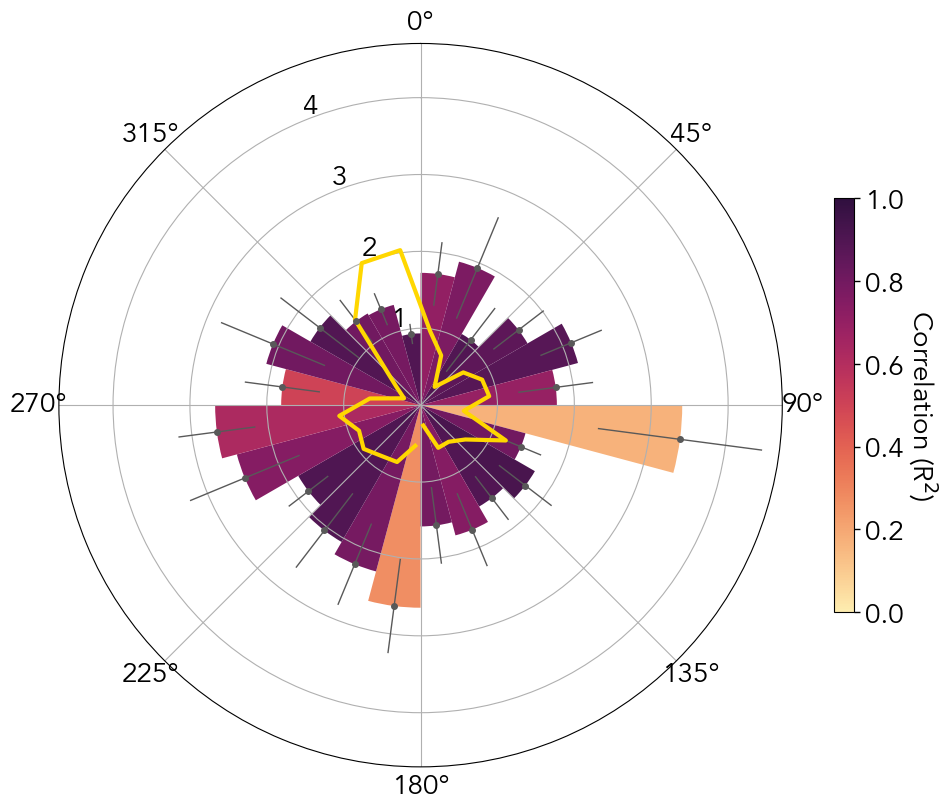

In [31]:
calculate_interval_statistics(ship_1h, era5_ship, interval_size=15)